In [1]:
from fastai import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import *
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types
from pathlib import Path
from utils import *

In [3]:
path = Path('/home/jupyter/data/')
path.ls()

[PosixPath('/home/jupyter/data/training.csv'),
 PosixPath('/home/jupyter/data/images'),
 PosixPath('/home/jupyter/data/data.pkl'),
 PosixPath('/home/jupyter/data/test.csv'),
 PosixPath('/home/jupyter/data/data.zip'),
 PosixPath('/home/jupyter/data/models'),
 PosixPath('/home/jupyter/data/temp.pkl')]

In [4]:
imgpath = path/'images'

In [5]:
df = pd.read_csv(path/'training.csv')
tdf = pd.read_csv(path/'training.csv')
df = df.set_index('image_name')
tdf['image_name'] = str(imgpath) +"/"+ tdf['image_name']
tdf = tdf.set_index('image_name')
df.head()

,x1,x2,y1,y2
image_name,,,,
JPEG_20160706_121146_1000145715002.png,115,495,143,325
JPEG_20161119_174038_1000690577600.png,23,457,61,409
147444927651111470309333776-Roadster-Men-Casual-Shoes-3041470309333487-1.png,37,601,13,470
147772332675720161028_161611.png,27,602,162,385
1473315333651DeeplearnS11638.png,60,586,174,325


The above annotations are in coco dataset format (x, y, width, height). The fastai library expects bbox coordinates to be in the format of (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin being in the upper left hand corner of the image.

In [6]:
SZ = 224
BS = 64
NUM_WORKERS = 12

In [7]:
def fn2bbox(fn):
    im_width, im_height = PIL.Image.open(fn).size
    row = tdf.loc[fn]
    return [
        np.clip(row['y2'],0,im_height),
        np.clip(row['x2'],0,im_width),
        np.clip(row['y1'],0,im_height),
        np.clip(row['x1'],0,im_width)
    ]

Just some small functions that will be helpful as we construct our dataset.

In [8]:
get_y_func = lambda o :  [[fn2bbox(o)], ['object']]

ObjectCategoryList is designed to be used in a full object recognition scenario (multiple bounding boxes per image, objects of multiple classes). Since that is more functionality than we require (and more than our model will predict - our objects will always be of the same class, 'fluke', and we will be predicting just a single bounding box per image) I make minor changes to ObjectCategoryList.

In [9]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [10]:
src = (ObjectItemList.from_df(pd.DataFrame(data=list(df.index)), path=path,folder = 'images')
        .random_split_by_pct()                   
        .label_from_func(get_y_func, label_cls=StubbedObjectCategoryList))

In [11]:
data = (src.transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS,collate_fn=bb_pad_collate)
        .normalize(imagenet_stats))

In [12]:
class ObjectDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [13]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [14]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [15]:
learn = Learner(data, ObjectDetector(arch=models.resnet50), loss_func=loss_fn)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [16]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [109]:
learn.freeze_to(-1)

In [32]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss
1,0.634937,0.847533
2,0.611181,0.840173
3,0.555570,0.787005
4,0.509576,0.604848


In [39]:
learn.unfreeze()

In [41]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr]

In [41]:
learn.fit_one_cycle(4, lrs, div_factor=20)

epoch,train_loss,valid_loss,
1,0.062636,0.048571,1.232046
2,0.056950,0.040390,1.194117
3,0.052518,0.036364,1.178740
4,0.048564,0.030228,1.143516


In [42]:
learn.save('stage-2')

In [39]:
learn.fit_one_cycle(9,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss
1,0.047336,0.028266
2,0.046443,0.029365
3,0.045620,0.030079
4,0.045304,0.028988
5,0.044191,0.028604
6,0.044406,0.027868
7,0.043988,0.028075
8,0.042818,0.028411
9,0.042347,0.026844


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


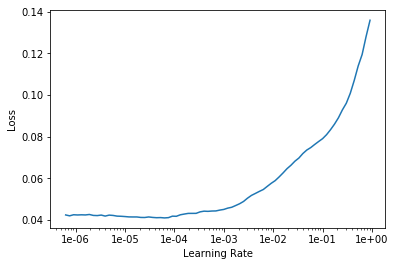

In [26]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(8,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.042989,0.026757,0.912621
2,0.043990,0.024793,0.920671
3,0.042548,0.025828,0.917263
4,0.042387,0.025667,0.917974
5,0.042048,0.024873,0.920132
6,0.042472,0.024582,0.920149
7,0.041452,0.026620,0.913779
8,0.040956,0.024694,0.920344


In [46]:
learn.fit_one_cycle(8,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.041036,0.025265,0.918272
2,0.042466,0.025467,0.916411
3,0.042433,0.026889,0.913872
4,0.040858,0.026115,0.914750
5,0.039270,0.024697,0.920473
6,0.040851,0.026375,0.914410
7,0.038960,0.024999,0.919030
8,0.039085,0.025080,0.918721


In [48]:
learn.fit_one_cycle(8,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.039209,0.025081,0.919111
2,0.039459,0.025599,0.917843
3,0.039918,0.025808,0.915844
4,0.039458,0.024903,0.919886
5,0.038793,0.024870,0.920479
6,0.038303,0.024745,0.919933
7,0.037886,0.025943,0.914137
8,0.037733,0.027694,0.910755


In [50]:
learn.fit_one_cycle(10,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.038020,0.025381,0.916872
2,0.038847,0.024871,0.919611
3,0.038019,0.027717,0.909469
4,0.038342,0.025364,0.918100
5,0.037547,0.026353,0.913659
6,0.037646,0.025081,0.919359
7,0.037523,0.024884,0.919746
8,0.037362,0.026224,0.914470
9,0.036665,0.024633,0.920633
10,0.036088,0.025565,0.916339


In [52]:
learn.fit_one_cycle(10,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.037115,0.025783,0.916519
2,0.037168,0.025482,0.916333
3,0.037295,0.026703,0.913779
4,0.037663,0.026553,0.913651
5,0.036640,0.025569,0.918405
6,0.036493,0.025745,0.916398
7,0.036170,0.025266,0.918731
8,0.035914,0.025893,0.917027
9,0.035431,0.025327,0.918815
10,0.036259,0.024403,0.920848


In [66]:
learn.fit_one_cycle(10,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.034983,0.024931,0.918108
2,0.035744,0.024456,0.920835
3,0.036864,0.027433,0.911842
4,0.036372,0.027667,0.908527
5,0.036888,0.025846,0.917107
6,0.035787,0.025823,0.916833
7,0.035318,0.025211,0.918034
8,0.034294,0.024939,0.919061
9,0.035316,0.025625,0.915546
10,0.033979,0.024703,0.920273


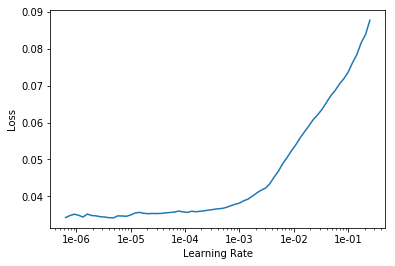

In [69]:
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(10,max_lr=slice(2e-6,1e-5))

epoch,train_loss,valid_loss,
1,0.035128,0.026266,0.913865
2,0.035455,0.024869,0.920540
3,0.035216,0.025044,0.921424
4,0.035266,0.024461,0.921212
5,0.034382,0.024971,0.919870
6,0.035167,0.024462,0.920579
7,0.034870,0.025951,0.914577
8,0.034498,0.024954,0.919072
9,0.034145,0.024774,0.919511
10,0.035003,0.024455,0.920808


In [18]:
learn.fit_one_cycle(8,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.034593,0.023428,0.920022
2,0.035002,0.023009,0.924379
3,0.036222,0.029710,0.900210
4,0.034533,0.024854,0.915248
5,0.034329,0.022096,0.925290
6,0.034652,0.023415,0.921376
7,0.034361,0.021259,0.928411
8,0.033838,0.022244,0.925153


In [34]:
learn.fit_one_cycle(8,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.034897,0.022544,0.923369
2,0.034970,0.023852,0.920048
3,0.034791,0.023488,0.921512
4,0.035272,0.026401,0.909711
5,0.035671,0.022219,0.926325
6,0.034137,0.022518,0.924481
7,0.033549,0.022679,0.922758
8,0.034244,0.022515,0.924207


In [35]:
learn.fit_one_cycle(8,max_lr=slice(2e-7,1e-5))

epoch,train_loss,valid_loss,
1,0.033684,0.022191,0.925635
2,0.033573,0.024314,0.920853
3,0.033151,0.022731,0.922969
4,0.034638,0.024095,0.918401
5,0.033311,0.023117,0.921966
6,0.032669,0.022377,0.924913
7,0.033690,0.021895,0.927314
8,0.033666,0.023767,0.921154


In [47]:
learn.fit_one_cycle(4,max_lr=slice(2e-8,1e-3))

epoch,train_loss,valid_loss,
1,0.033535,0.024256,0.915180
2,0.035580,0.021306,0.927902
3,0.034376,0.020525,0.930093
4,0.032541,0.020891,0.930059


In [18]:
learn.fit_one_cycle(8,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.033255,0.018479,0.935763
2,0.034216,0.017939,0.938470
3,0.033929,0.019399,0.932602
4,0.033869,0.019478,0.931468
5,0.032830,0.019512,0.935170
6,0.033203,0.019698,0.931349
7,0.033178,0.019964,0.930755
8,0.032539,0.018703,0.934724


In [31]:
learn.fit_one_cycle(8,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.032774,0.018860,0.934268
2,0.032809,0.018616,0.935377
3,0.033932,0.019792,0.932349
4,0.033436,0.021783,0.927492
5,0.033250,0.019596,0.931009
6,0.032501,0.019596,0.930679
7,0.032856,0.019295,0.932592
8,0.032887,0.018405,0.935049


In [32]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.032538,0.020450,0.928599
2,0.032135,0.018805,0.934348
3,0.033599,0.021015,0.927093
4,0.033541,0.020196,0.929742
5,0.033914,0.019679,0.931692
6,0.033273,0.020155,0.931189
7,0.033309,0.021409,0.925478
8,0.033361,0.018868,0.934861
9,0.032507,0.020027,0.932377
10,0.031989,0.019685,0.930717


In [35]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.032597,0.018839,0.934915
2,0.032062,0.020744,0.928134
3,0.032870,0.020453,0.928207
4,0.032867,0.019686,0.932237
5,0.033027,0.020429,0.929808
6,0.033554,0.019934,0.931542
7,0.031975,0.019221,0.933179
8,0.031888,0.021083,0.925916
9,0.032340,0.018927,0.933173
10,0.032307,0.018836,0.934652


In [47]:
learn.fit_one_cycle(16,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.030901,0.018802,0.935193
2,0.031676,0.019192,0.933976
3,0.031976,0.020371,0.929930
4,0.032667,0.020255,0.929800
5,0.032432,0.020844,0.927993
6,0.032993,0.021481,0.925622
7,0.033302,0.019707,0.932799
8,0.032618,0.019001,0.934664
9,0.031216,0.019972,0.930885
10,0.031993,0.023399,0.918126


In [48]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.031337,0.020429,0.927986
2,0.031228,0.019103,0.933816
3,0.031621,0.018726,0.935854
4,0.031438,0.019990,0.930237
5,0.031916,0.020970,0.926578
6,0.031786,0.020203,0.929543
7,0.031509,0.021647,0.925007
8,0.031470,0.020067,0.931541
9,0.030750,0.019790,0.932792
10,0.031270,0.020615,0.928880


In [61]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.030985,0.019777,0.931437
2,0.030529,0.020135,0.930821
3,0.031806,0.019392,0.932799
4,0.031980,0.024151,0.919377
5,0.031924,0.021959,0.924144
6,0.031608,0.021092,0.927577
7,0.030655,0.018942,0.935194
8,0.030921,0.019575,0.933260
9,0.030613,0.019556,0.933350
10,0.030195,0.019360,0.933099


In [74]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.030405,0.020917,0.928849
2,0.030460,0.020422,0.929549
3,0.030908,0.021849,0.923948
4,0.031799,0.020266,0.930307
5,0.030896,0.020204,0.929565
6,0.031063,0.022525,0.922562
7,0.030785,0.019634,0.933370
8,0.030341,0.021367,0.926276
9,0.029498,0.018885,0.935027
10,0.029861,0.019339,0.933660


In [86]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.029367,0.018774,0.935975
2,0.029895,0.018576,0.934919
3,0.029670,0.021248,0.925572
4,0.030664,0.020265,0.929818
5,0.030347,0.023348,0.918755
6,0.031273,0.020648,0.929659
7,0.030948,0.021655,0.925223
8,0.030169,0.019559,0.933047
9,0.030482,0.020774,0.927145
10,0.029076,0.019579,0.931760


In [99]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.029014,0.020169,0.930386
2,0.029632,0.019622,0.932849
3,0.029575,0.020478,0.928693
4,0.030507,0.020554,0.931193
5,0.030356,0.021776,0.922411
6,0.029563,0.022000,0.923664
7,0.030196,0.021375,0.926880
8,0.030062,0.022248,0.922662
9,0.029685,0.019426,0.932564
10,0.029325,0.020015,0.932668


In [101]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.028479,0.018832,0.936333
2,0.029394,0.020716,0.929525
3,0.029458,0.022651,0.922258
4,0.029767,0.018693,0.936784
5,0.031069,0.020383,0.929113
6,0.030333,0.020329,0.929681
7,0.030244,0.020731,0.928514
8,0.029662,0.021034,0.928958
9,0.028632,0.019223,0.934128
10,0.029027,0.019903,0.930878


In [102]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.028346,0.019326,0.932841
2,0.028933,0.018766,0.935910
3,0.029663,0.021601,0.928534
4,0.031165,0.021851,0.925037
5,0.031209,0.021004,0.928532
6,0.029782,0.019964,0.931477
7,0.029174,0.019126,0.934633
8,0.029794,0.020044,0.930289
9,0.029058,0.019567,0.932870
10,0.029411,0.020045,0.930167


In [115]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.028960,0.020148,0.930615
2,0.029063,0.022918,0.921607
3,0.030715,0.020337,0.929984
4,0.030277,0.023280,0.919693
5,0.029249,0.020667,0.929834
6,0.029501,0.020167,0.930672
7,0.029335,0.022942,0.919565
8,0.029438,0.018695,0.936764
9,0.028771,0.020854,0.928631
10,0.028663,0.019722,0.932807


In [117]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,5e-4))

epoch,train_loss,valid_loss,
1,0.028670,0.019531,0.931869
2,0.029904,0.022937,0.921676
3,0.031490,0.023277,0.919284
4,0.032354,0.024857,0.918545
5,0.032259,0.020762,0.929213
6,0.031860,0.028468,0.903511
7,0.031993,0.021171,0.929550
8,0.031388,0.021669,0.925356
9,0.030202,0.020177,0.932636
10,0.029412,0.019604,0.934529


In [18]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.028414,0.016268,0.942437
2,0.028711,0.016992,0.940304
3,0.029558,0.015677,0.946120
4,0.029600,0.018904,0.933166
5,0.031047,0.018588,0.933862
6,0.030336,0.016913,0.943186
7,0.029512,0.018529,0.936075
8,0.029613,0.018044,0.936660
9,0.029389,0.016808,0.942316
10,0.028900,0.016432,0.943010


In [32]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.028143,0.017743,0.940070
2,0.028438,0.016325,0.944384
3,0.029765,0.017758,0.938920
4,0.030316,0.019645,0.934101
5,0.030091,0.017750,0.939151
6,0.030436,0.018775,0.934684
7,0.029924,0.017085,0.940146
8,0.029264,0.018581,0.935256
9,0.028292,0.016144,0.945617
10,0.028898,0.017379,0.939721


In [33]:
learn.fit_one_cycle(20,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.027907,0.015485,0.947646
2,0.027901,0.016249,0.944253
3,0.028133,0.016659,0.942382
4,0.029096,0.019662,0.931727
5,0.028969,0.018431,0.938225
6,0.030304,0.023462,0.921887
7,0.030412,0.018209,0.938986
8,0.030148,0.018499,0.938115
9,0.029484,0.019210,0.933332
10,0.029995,0.019581,0.932650


In [34]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.027769,0.016518,0.943220
2,0.027902,0.017980,0.938570
3,0.029367,0.019274,0.934429
4,0.029502,0.017639,0.941225
5,0.029604,0.018037,0.939121
6,0.029897,0.018771,0.937166
7,0.028332,0.016961,0.941860
8,0.028426,0.017719,0.938625
9,0.028485,0.016746,0.943316
10,0.027715,0.016579,0.944035


In [38]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.027866,0.016289,0.944464
2,0.027876,0.016600,0.944242
3,0.027858,0.017223,0.941887
4,0.029456,0.018907,0.936688
5,0.028700,0.018794,0.935601
6,0.028500,0.018138,0.939867
7,0.029080,0.019785,0.930780
8,0.027820,0.018428,0.937104
9,0.028016,0.018163,0.938060
10,0.027567,0.017537,0.940135


In [39]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.027641,0.016921,0.942403
2,0.027723,0.019213,0.933484
3,0.028248,0.019935,0.930312
4,0.029704,0.020471,0.929567
5,0.028826,0.017494,0.939244
6,0.028427,0.018950,0.936041
7,0.027986,0.017762,0.940365
8,0.027861,0.018182,0.938164
9,0.028245,0.017623,0.938916
10,0.027558,0.017006,0.942796


In [40]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.027174,0.017009,0.942301
2,0.027589,0.018267,0.937544
3,0.028020,0.021343,0.928589
4,0.028084,0.017011,0.942529
5,0.028694,0.019826,0.932185
6,0.028095,0.017418,0.940995
7,0.028379,0.018003,0.938000
8,0.028263,0.019270,0.934246
9,0.027187,0.016426,0.944687
10,0.027445,0.016977,0.942589


In [53]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.027451,0.017836,0.938964
2,0.028014,0.020043,0.930733
3,0.028422,0.018752,0.937787
4,0.027832,0.017069,0.943074
5,0.028168,0.027250,0.905713
6,0.028618,0.018041,0.940526
7,0.028082,0.019703,0.932543
8,0.027210,0.017483,0.941712
9,0.026924,0.016574,0.944529
10,0.026846,0.017841,0.940134


In [54]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.027112,0.016829,0.943866
2,0.026761,0.017399,0.940588
3,0.028182,0.022674,0.921217
4,0.029144,0.022127,0.928483
5,0.028550,0.018546,0.937259
6,0.028088,0.018628,0.936329
7,0.027708,0.019054,0.935365
8,0.027480,0.018263,0.938710
9,0.027009,0.017773,0.938918
10,0.027105,0.017296,0.941241


In [56]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.026458,0.016765,0.942873
2,0.027302,0.017366,0.942743
3,0.027195,0.017533,0.941299
4,0.027475,0.019996,0.934237
5,0.027596,0.017812,0.940500
6,0.028364,0.018407,0.938285
7,0.026785,0.017949,0.940259
8,0.026382,0.017595,0.941250
9,0.026516,0.017574,0.940427
10,0.026637,0.018193,0.938439


In [58]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.026858,0.017310,0.942501
2,0.026253,0.018178,0.938992
3,0.028081,0.017613,0.940483
4,0.028093,0.020230,0.931197
5,0.027801,0.017983,0.938606
6,0.028404,0.023619,0.918197
7,0.027402,0.019458,0.935801
8,0.027383,0.017889,0.941017
9,0.026461,0.017501,0.940241
10,0.026553,0.017722,0.940640


In [60]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.026165,0.018140,0.938067
2,0.026479,0.017440,0.940678
3,0.027542,0.018054,0.939571
4,0.028378,0.017826,0.940123
5,0.027578,0.017702,0.939835
6,0.027440,0.017812,0.940167
7,0.027154,0.018366,0.937525
8,0.027284,0.017957,0.941161
9,0.026556,0.017134,0.942896
10,0.026467,0.017364,0.941535


In [74]:
learn.wd = 0

In [75]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.026157,0.017519,0.940194
2,0.026178,0.017234,0.942125
3,0.026643,0.017698,0.939781
4,0.027366,0.018352,0.937663
5,0.027495,0.020041,0.931889
6,0.027036,0.024312,0.918715
7,0.026247,0.017711,0.940417
8,0.026230,0.017495,0.940906
9,0.026504,0.017290,0.941980
10,0.025976,0.017287,0.941681


In [77]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.025736,0.017322,0.940681
2,0.026905,0.020848,0.928700
3,0.027001,0.023800,0.919650
4,0.027444,0.020882,0.928625
5,0.027175,0.025175,0.914427
6,0.026939,0.022446,0.923367
7,0.026561,0.018168,0.939584
8,0.026475,0.018483,0.936837
9,0.025430,0.017216,0.942243
10,0.026024,0.017767,0.939302


In [79]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.025904,0.017383,0.941259
2,0.025722,0.017058,0.942672
3,0.027880,0.022782,0.923626
4,0.026504,0.019199,0.934453
5,0.026214,0.018576,0.937147
6,0.026840,0.024402,0.915708
7,0.026697,0.019520,0.932900
8,0.026148,0.017614,0.940159
9,0.025718,0.017288,0.941757
10,0.025912,0.018390,0.937879


In [81]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.025051,0.016801,0.943466
2,0.025802,0.017393,0.941468
3,0.026436,0.021180,0.926013
4,0.026789,0.018161,0.939710
5,0.026597,0.018660,0.936185
6,0.026791,0.019046,0.936136
7,0.026087,0.019046,0.935134
8,0.025451,0.017821,0.940384
9,0.025518,0.017309,0.942043
10,0.026096,0.017455,0.941251


In [82]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.025497,0.018027,0.939516
2,0.025601,0.017765,0.941305
3,0.027218,0.018463,0.939489
4,0.026145,0.018283,0.938505
5,0.026714,0.019777,0.933073
6,0.026851,0.019346,0.935456
7,0.025890,0.017833,0.940773
8,0.025641,0.018865,0.936739
9,0.025222,0.017807,0.940739
10,0.024691,0.017579,0.940985


In [95]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.024961,0.017000,0.943097
2,0.025899,0.019695,0.931829
3,0.026461,0.020104,0.932817
4,0.027314,0.019193,0.936164
5,0.026223,0.021547,0.929174
6,0.027209,0.021804,0.926191
7,0.026425,0.018866,0.938149
8,0.025451,0.019394,0.933308
9,0.025578,0.017290,0.943317
10,0.025398,0.018351,0.938521


In [97]:
learn.fit_one_cycle(24,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.024917,0.018528,0.938328
2,0.024732,0.017489,0.940864
3,0.025147,0.017355,0.941982
4,0.025347,0.017349,0.942343
5,0.026053,0.020551,0.928437
6,0.027151,0.019568,0.935238
7,0.027352,0.019581,0.935643
8,0.026565,0.018460,0.937278
9,0.026453,0.019302,0.936135
10,0.026841,0.020514,0.931050


In [112]:
learn.fit_one_cycle(24,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.024521,0.017642,0.941390
2,0.024464,0.018397,0.938595
3,0.024227,0.017484,0.941548
4,0.024895,0.020983,0.928103
5,0.025324,0.018656,0.937585
6,0.025727,0.018368,0.939018
7,0.026663,0.020145,0.931393
8,0.027188,0.020866,0.930649
9,0.025875,0.018702,0.937916
10,0.026516,0.021192,0.930036


In [114]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-5))

epoch,train_loss,valid_loss,
1,0.024378,0.017444,0.941211
2,0.024033,0.018319,0.939295
3,0.024465,0.019104,0.934487
4,0.024408,0.017535,0.941188
5,0.024123,0.021113,0.927146
6,0.024235,0.018192,0.937619
7,0.024726,0.017259,0.941956
8,0.023987,0.017822,0.940500
9,0.023984,0.017664,0.941390
10,0.023790,0.017426,0.941660


In [ ]:
learn.fit_one_cycle(12,max_lr=slice(2e-6,1e-4))

epoch,train_loss,valid_loss,
1,0.023903,0.017113,0.942747
2,0.024337,0.018670,0.936907
3,0.025160,0.019241,0.935155
4,0.026043,0.019680,0.933792
5,0.025026,0.017826,0.940648
6,0.025206,0.019032,0.937143
7,0.026724,0.019556,0.934965
8,0.024841,0.018526,0.938092
9,0.024751,0.018007,0.939343
10,0.024494,0.018790,0.937416


In [113]:
learn.save('stage-3')

In [99]:
preds, targs = learn.get_preds()

In [100]:
def denorm(im,bbox):
    shape =  im.size
    h = shape[0]
    w = shape[1]
    bbox = (bbox + 1)/2
    bbox[0] = bbox[0]*h
    bbox[2] = bbox[2]*h
    bbox[1] = bbox[1]*w
    bbox[3] = bbox[3]*w
    return bbox

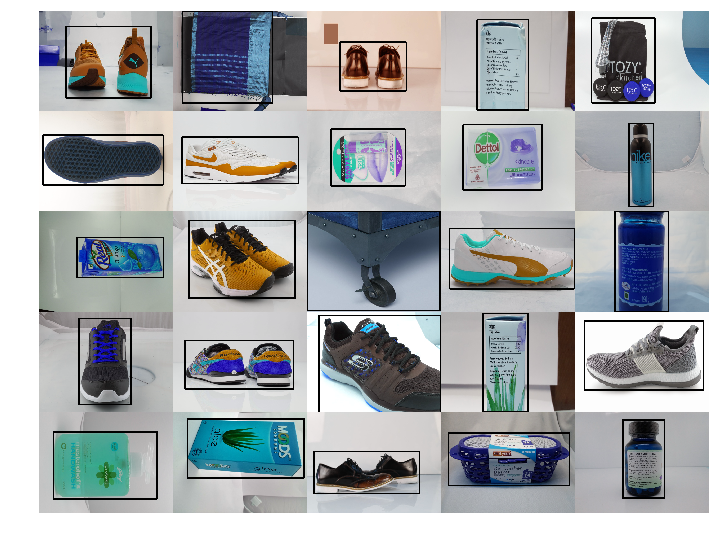

In [101]:
# temppath = imgpath/'JPEG_20160706_121146_1000145715002.png'
def draw_bbox(temppath):
    im = open_image(temppath)
    preds = learn.predict(im)
    preds = denorm(im,preds[2].numpy())
    ymin,xmin,ymax,xmax = map(int,preds)
    im = cv2.imread(str(temppath))
    cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color=(0,0,0), thickness=5)
    return im

ims = np.stack([draw_bbox(data.valid_ds.items[i]) for i in range(25)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

In [102]:
test = pd.read_csv(path/'test.csv')
test.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


In [103]:
def filltest(temppath):
    im = open_image(temppath)
    preds = learn.predict(im)
    preds = denorm(im,preds[2].numpy())
    y1,x1,y2,x2 = preds
    return x1,y1,x2,y2

In [104]:
print(filltest(imgpath/'JPEG_20160706_121146_1000145715002.png'))

(114.54941, 139.9185, 495.67706, 326.85513)


In [105]:
for i,row in test.iterrows():
    p = row['image_name']
    
    
    
    
    
    
    x1,y1,x2,y2 = filltest(imgpath/p)
    test.at[i,'x1'] = round(x1)
    test.at[i,'x2'] = round(x2)
    test.at[i,'y1'] = round(y1)
    test.at[i,'y2'] = round(y2)
    if i%1000 == 0 : print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [106]:
test.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,231.0,449.0,85.0,406.0
1,1473231475010DeeplearnS11276.png,79.0,573.0,137.0,351.0
2,JPEG_20161205_135307_1000155917326.png,144.0,499.0,52.0,433.0
3,JPEG_20160711_123440_1000518778437.png,211.0,465.0,95.0,414.0
4,JPEG_20160803_115329_100034020722.png,133.0,506.0,41.0,437.0


In [107]:
def draw_from_df(df):
    ims = []
    for i,row in df.iterrows():
        p = row['image_name']
        im = open_image(imgpath/p)
        y1 = int(row['y1'])
        x1 = int(row['x1'])
        y2 = int(row['y2'])
        x2 = int(row['x2'])
        im = cv2.imread(str(imgpath/p))
        cv2.rectangle(im, (x1, y1), (x2, y2),(0,0,0), thickness=5)
        ims.append(im)
    ims = np.stack(ims)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(montage(np.stack(ims), multichannel=True))

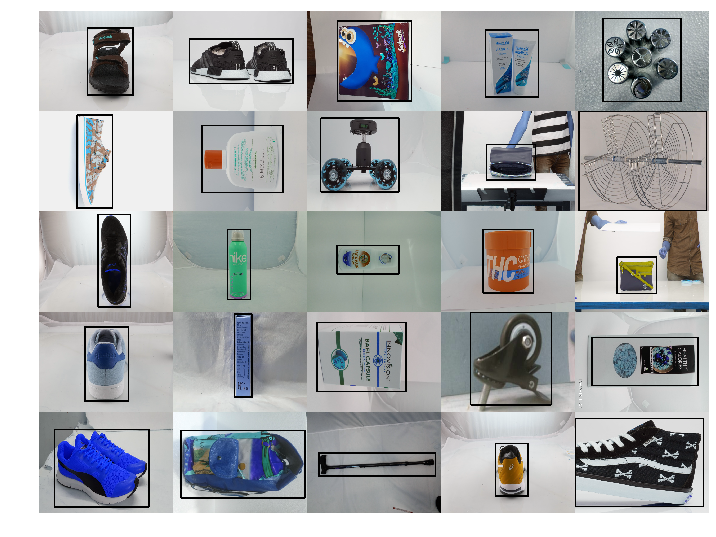

In [108]:
draw_from_df(test.head(25))

In [111]:
# test = test.set_index('image_name')
test.to_csv('ans.csv')